## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
import pandas as pd

# params = {'k1': k1_values, 'k2': k2_values, ...}
# list multi-dimension parameter comnbinations
def to_params_dataframe(params):
    df_list = []
    for (i, (key, values)) in enumerate(params.items()):
        df_list.append(pd.DataFrame({key: values}))
    
    return df_combinations(df_list)    
    
def df_combinations(df_list):
    df_merged = df_list[0].copy()
    for df in df_list[1:]:
        df_merged = df_merged.assign(tmp_key=1).merge(df.assign(tmp_key=1)).drop('tmp_key', 1)
    return df_merged

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
import numpy as np
def to_int(bool_val):
    return int(bool_val == 'true')

def to_val(val):
    if type(val) == np.bool_:
        return str(val.astype(int))
    elif type(val) == bool:
        return str(to_int(val))
    else:
        return str(val)

# ref: Day89  loss function callback    (nested lambda function for embedded variable scope)
def to_filename(cols=[], cols_abbr={}):
    cols_abbr = dict(zip(v_cols, v_cols)) if not cols_abbr else cols_abbr
    def inner(row):
        s = '__'.join([f"{cols_abbr[col]}_{to_val(row[col])}" for col in cols])
        return f'./model/{s}.h5'
    return inner
    
def to_rowkey(cols=[]):
    cols = cols
    def inner(row):
        s = ' '.join([f'{col}:{to_val(row[col])}' for col in cols])
        return f"{s}"
    return inner

def to_plot_legend(cols=[], cols_abbr={}):
    cols = cols
    cols_abbr = dict(zip(cols, cols)) if not cols_abbr else cols_abbr
    def inner(row):
        s = '_'.join([f'{cols_abbr[col]}:{to_val(row[col])}' for col in cols])
        return f'{s}'
    return inner

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    print(input_layer.shape)
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

Bug: pandas DataFrame apply function cannot call multiple times,
    the first call is correct, but follow calls always return some cache value  
[DOC: df.iterrows() returns view for homogenous columns, and copy for heterogenous / perf warning #7194](https://github.com/pandas-dev/pandas/issues/7194)

新增欄位時, 引用row自身導致

In [9]:
KEY_SAVE_BEST_ONLY    = 'save_best_only'
KEY_SAVE_WEIGHTS_ONLY = 'save_weights_only'

KEY_EXT_MODEL_FILE  = '$model_file$'
KEY_EXT_PLOT_LEGEND = '$plot_legend$'
KEY_EXT_ROWKEY      = '$rowkey$'

## 測試參數設定
opts_save_best_only    = [False, True]
opts_save_weights_only = [True, False]

param_opts = {
    KEY_SAVE_BEST_ONLY   : opts_save_best_only,
    KEY_SAVE_WEIGHTS_ONLY: opts_save_weights_only,
}

opts_abbr = {
    KEY_SAVE_BEST_ONLY    : 'best_only',
    KEY_SAVE_WEIGHTS_ONLY : 'weights_only',
}
print(f"\ntest parameters:\n{'- '*30}\n{param_opts}")
 
df_opts = to_params_dataframe(param_opts)

print(f"\ntest runs: {len(df_opts)}\n{'=-'*30}\n{df_opts}")

# 新增欄位
raw_cols=[x for x in param_opts.keys()]
# 以下呼叫兩次apply, 'KEY_EXT_PLOT_LEGEND' 欄位資料會設值錯誤
#df_opts[KEY_EXT_MODEL_FILE]  = df_opts.apply(to_filename(raw_cols, opts_abbr), axis=1)
#df_opts[KEY_EXT_PLOT_LEGEND] = df_opts.apply(to_plot_legend(raw_cols, opts_abbr), axis=1)
# 改成以下寫法
df_opts[KEY_EXT_ROWKEY]      = df_opts[raw_cols].apply(to_rowkey(raw_cols), axis=1)
df_opts[KEY_EXT_MODEL_FILE]  = df_opts[raw_cols].apply(to_filename(raw_cols, opts_abbr), axis=1)
df_opts[KEY_EXT_PLOT_LEGEND] = df_opts[raw_cols].apply(to_plot_legend(raw_cols, opts_abbr), axis=1)
# 另一種寫法
#df_opts[KEY_EXT_PLOT_LEGEND] = df_opts[raw_cols].apply(lambda row: to_plot_legend(raw_cols, opts_abbr)(row), axis=1)

print(f"\ndf_opts:\n{'=-'*30}\n{df_opts}")


test parameters:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
{'save_best_only': [False, True], 'save_weights_only': [True, False]}

test runs: 4
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
   save_best_only  save_weights_only
0           False               True
1           False              False
2            True               True
3            True              False

df_opts:
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
   save_best_only  save_weights_only                              $rowkey$  \
0           False               True  save_best_only:0 save_weights_only:1   
1           False              False  save_best_only:0 save_weights_only:0   
2            True               True  save_best_only:1 save_weights_only:1   
3            True              False  save_best_only:1 save_weights_only:0   

                             $model_file$               $plot_legend$  
0  ./model/best_only_0__weights_only_1.h5  best_only:0_we

In [10]:
def load_model(model_file_path, save_weights_only):
    if save_weights_only == True:
        model = build_mlp(input_shape=x_train.shape[1:])
        model.load_weights(model_file_path)
    else:
        model = keras.models.load_model(model_file_path)
    
    return model

In [11]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

results = {}

y_test_class_n = np.argmax(y_test, axis=1)
for idx, params in df_opts.iterrows():
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    p_save_best_only    = params[KEY_SAVE_BEST_ONLY]
    p_save_weights_only = params[KEY_SAVE_WEIGHTS_ONLY]
    p_model_file        = params[KEY_EXT_MODEL_FILE]
    
    model_ckpt = ModelCheckpoint(filepath=p_model_file, 
                             monitor="val_loss", 
                             verbose=1,
                             save_best_only=p_save_best_only,
                             save_weights_only = p_save_weights_only
                        )
    
    model = build_mlp(input_shape=x_train.shape[1:])
    print(model.summary())

    print()
    print('-'*60)
    print(f"Experiment with : \n{params}")
    print()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    y_pred = model.predict(x_test)
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"acc(test)={test_acc:.4f}; loss(test)={test_loss:.4f}")

    # ----------------------------------
    # Load back
    keras.backend.clear_session()

    print('-'*60)
    model_loadback = load_model(p_model_file, p_save_weights_only)
    print(model_loadback.summary())

    y_pred_loadback = model_loadback.predict(x_test)
    
    if p_save_weights_only:
        model_loadback.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    loss_loadback, acc_loadback = model_loadback.evaluate(x_test, y_test)
    print(f"acc(loadback)={acc_loadback:.4f}; loss(loadback)={loss_loadback:.4f}")

    #print(y_test[:5])
    #print(y_pred[:5])
    #print(y_pred_loadback[:5])
    #print()
    #print(y_test_class_n[:5].ravel())
    #print(np.argmax(y_pred         , axis=1)[:5].ravel())
    #print(np.argmax(y_pred_loadback, axis=1)[:5].ravel())
    
    pred_acc_original = accuracy_score(y_test_class_n, np.argmax(y_pred         , axis=1))
    pred_acc_loadback = accuracy_score(y_test_class_n, np.argmax(y_pred_loadback, axis=1))
    
    # Collect results
    exp_name_tag = params[KEY_EXT_PLOT_LEGEND]
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'test-acc': test_acc,
                             'test-loss': test_loss,
                             'loadback-acc': acc_loadback,
                             'loadback-loss': loss_loadback,
                             'original-pred-acc': pred_acc_original,
                             'loadback-pred-acc': pred_acc_loadback,
                             'model_file': p_model_file,
                             'params': params
                            }  

Instructions for updating:
Colocations handled automatically by placer.
(?, 3072)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________________________________


Epoch 00028: saving model to ./model/best_only_0__weights_only_1.h5
Epoch 29/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.8854 - acc: 0.7053 - val_loss: 1.4815 - val_acc: 0.4974

Epoch 00029: saving model to ./model/best_only_0__weights_only_1.h5
Epoch 30/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.8674 - acc: 0.7122 - val_loss: 1.4719 - val_acc: 0.5003

Epoch 00030: saving model to ./model/best_only_0__weights_only_1.h5
Epoch 31/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.8475 - acc: 0.7215 - val_loss: 1.4809 - val_acc: 0.5046

Epoch 00031: saving model to ./model/best_only_0__weights_only_1.h5
Epoch 32/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.8289 - acc: 0.7276 - val_loss: 1.4939 - val_acc: 0.5005

Epoch 00032: saving model to ./model/best_only_0__weights_only_1.h5
Epoch 33/50
50000/50000 [==============================] - 10s 209us/step - loss: 0.8092 - acc: 0

50000/50000 [==============================] - 12s 231us/step - loss: 2.2400 - acc: 0.2704 - val_loss: 2.1784 - val_acc: 0.3152

Epoch 00001: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 2/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.7429 - acc: 0.3957 - val_loss: 1.8036 - val_acc: 0.3871

Epoch 00002: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 3/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6179 - acc: 0.4354 - val_loss: 1.6697 - val_acc: 0.4223

Epoch 00003: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 4/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.5447 - acc: 0.4617 - val_loss: 1.6356 - val_acc: 0.4336

Epoch 00004: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 5/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4909 - acc: 0.4800 - val_loss: 1.5789 - val_acc: 0.4492

Epoch 00005: saving model to ./model/best_o

50000/50000 [==============================] - 10s 207us/step - loss: 0.6606 - acc: 0.7981 - val_loss: 1.5566 - val_acc: 0.5010

Epoch 00040: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 41/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.6441 - acc: 0.8050 - val_loss: 1.5754 - val_acc: 0.4949

Epoch 00041: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 42/50
50000/50000 [==============================] - 9s 180us/step - loss: 0.6229 - acc: 0.8129 - val_loss: 1.5591 - val_acc: 0.4992

Epoch 00042: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 43/50
50000/50000 [==============================] - 9s 180us/step - loss: 0.6066 - acc: 0.8188 - val_loss: 1.5797 - val_acc: 0.4994

Epoch 00043: saving model to ./model/best_only_0__weights_only_0.h5
Epoch 44/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.5884 - acc: 0.8286 - val_loss: 1.5884 - val_acc: 0.4956

Epoch 00044: saving model to ./model/b

50000/50000 [==============================] - 9s 185us/step - loss: 1.2823 - acc: 0.5551 - val_loss: 1.4964 - val_acc: 0.4679

Epoch 00011: val_loss improved from 1.50522 to 1.49641, saving model to ./model/best_only_1__weights_only_1.h5
Epoch 12/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.2535 - acc: 0.5670 - val_loss: 1.4831 - val_acc: 0.4793

Epoch 00012: val_loss improved from 1.49641 to 1.48309, saving model to ./model/best_only_1__weights_only_1.h5
Epoch 13/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2273 - acc: 0.5760 - val_loss: 1.4805 - val_acc: 0.4779

Epoch 00013: val_loss improved from 1.48309 to 1.48053, saving model to ./model/best_only_1__weights_only_1.h5
Epoch 14/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.2013 - acc: 0.5848 - val_loss: 1.4645 - val_acc: 0.4869

Epoch 00014: val_loss improved from 1.48053 to 1.46449, saving model to ./model/best_only_1__weights_only_1.h5
Epoch 15

10000/10000 [==============================] - 2s 168us/step
acc(loadback)=0.4967; loss(loadback)=1.4495
(?, 3072)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________

50000/50000 [==============================] - 9s 182us/step - loss: 0.8934 - acc: 0.7020 - val_loss: 1.4632 - val_acc: 0.5060

Epoch 00028: val_loss did not improve from 1.45066
Epoch 29/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.8719 - acc: 0.7098 - val_loss: 1.4601 - val_acc: 0.5069

Epoch 00029: val_loss did not improve from 1.45066
Epoch 30/50
50000/50000 [==============================] - 9s 180us/step - loss: 0.8525 - acc: 0.7170 - val_loss: 1.4702 - val_acc: 0.5015

Epoch 00030: val_loss did not improve from 1.45066
Epoch 31/50
50000/50000 [==============================] - 9s 179us/step - loss: 0.8317 - acc: 0.7270 - val_loss: 1.4778 - val_acc: 0.5024

Epoch 00031: val_loss did not improve from 1.45066
Epoch 32/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.8124 - acc: 0.7358 - val_loss: 1.5068 - val_acc: 0.4988

Epoch 00032: val_loss did not improve from 1.45066
Epoch 33/50
50000/50000 [==============================] 

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data(results, title=''):
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(24, 8)
    #plt.subplots_adjust(bottom=.05, top=.9, hspace=.9)

    fig.suptitle(title)

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax1.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax1.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
        ax1.hlines(y=results[cond]['loadback-loss'], xmin=0, xmax=len(results[cond]['train-loss']), color=color_bar[i], linestyles=':')
    ax1.set_title("Loss")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax2.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax2.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
        ax2.hlines(y=results[cond]['loadback-acc'], xmin=0, xmax=len(results[cond]['train-acc']), color=color_bar[i], linestyles=':')
    ax2.set_title("Accuracy")
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
   
    plt.show()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data_2(results, title=''):
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
        plt.hlines(y=results[cond]['loadback-loss'], xmin=0, xmax=len(results[cond]["train-loss"]), color=color_bar[i], linestyles=':')
    plt.title(f"Loss {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    plt.clf()
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
        plt.hlines(y=results[cond]['loadback-acc'], xmin=0, xmax=len(results[cond]['train-acc']), color=color_bar[i], linestyles=':')
    plt.title(f"Accuracy {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    print('='*80)
    print()

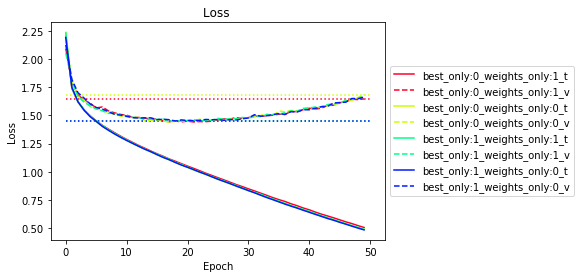

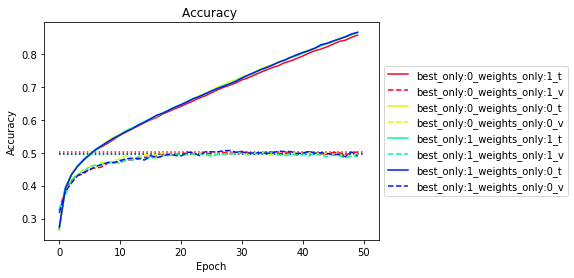

In [14]:
plot_data_2(results)

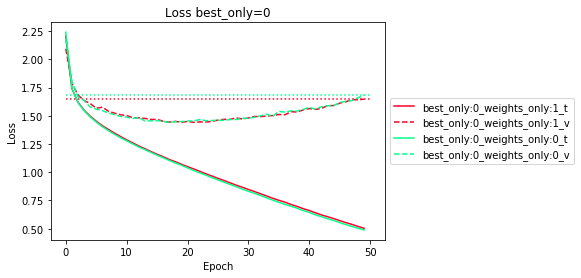

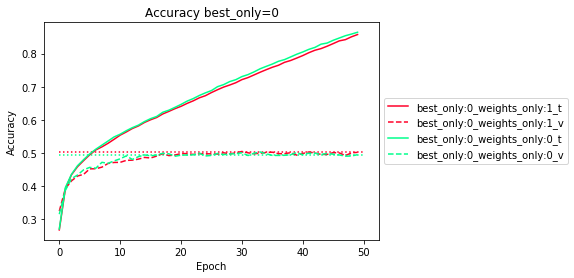

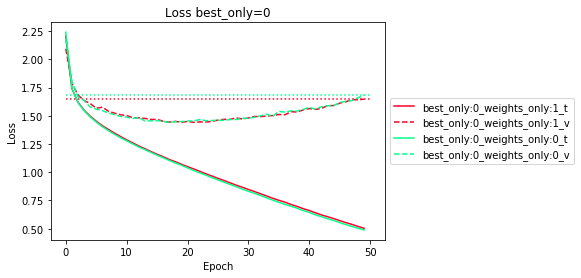

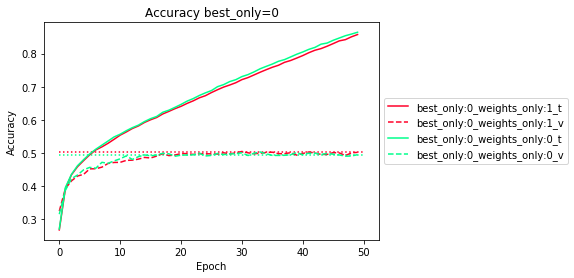

In [15]:
for save_best_only in opts_save_best_only:
    kv_pair = f'{opts_abbr[KEY_SAVE_BEST_ONLY]}:{to_int(save_best_only)}'
    results_by_key = {k: v for k, v in results.items() if kv_pair in k}
    plot_data_2(results_by_key, title=kv_pair.replace(':', '='))

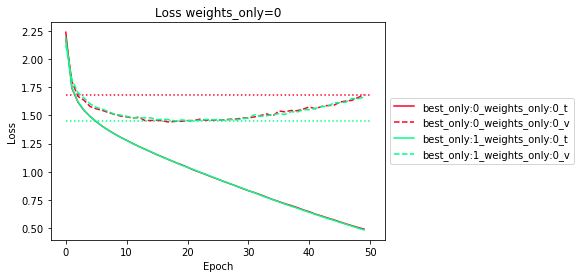

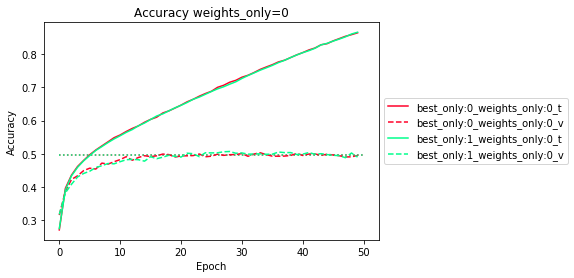

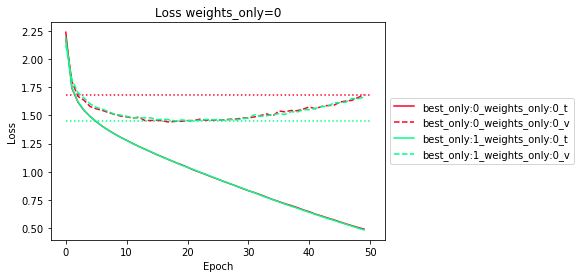

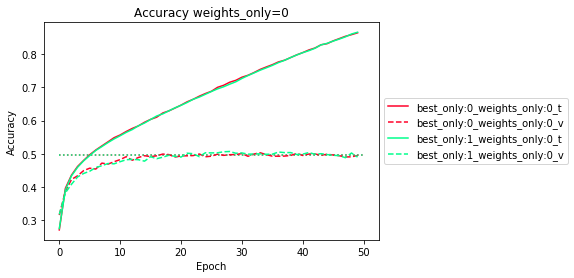

In [16]:
for save_weights_only in opts_save_weights_only:
    kv_pair = f'{opts_abbr[KEY_SAVE_WEIGHTS_ONLY]}:{to_int(save_weights_only)}'
    results_by_key = {k: v for k, v in results.items() if kv_pair in k}
    plot_data_2(results_by_key, title=kv_pair.replace(':', '='))

In [19]:
for (i, (key, result)) in enumerate(results.items()):
    keras.backend.clear_session()
    
    model_file = result['model_file']
    params = result['params']
    save_best_only = params[KEY_SAVE_BEST_ONLY]
    save_weights_only = params[KEY_SAVE_WEIGHTS_ONLY]

    test_acc = result['test-acc']
    test_loss = result['test-loss']
    acc_loadback = result['loadback-acc']
    loss_loadback = result['loadback-loss']

    pred_acc_original = result['original-pred-acc']
    pred_acc_loadback = result['loadback-pred-acc']
    
    print('-'*60)
    print(f"save_best_only={save_best_only}; save_weights_only={save_weights_only}")
    print(f"model_file={model_file}")
    print(f"acc(test)    ={test_acc:.4f}; \t loss(test)    ={test_loss:.4f}")
    print(f"acc(loadback)={acc_loadback:.4f}; \t loss(loadback)={loss_loadback:.4f}")
    print(f"pred_acc(original <==> loadback)={pred_acc_original:.4f} <==> {pred_acc_loadback:.4f}")
    

------------------------------------------------------------
save_best_only=False; save_weights_only=True
model_file=./model/best_only_0__weights_only_1.h5
acc(test)    =0.5019; 	 loss(test)    =1.6471
acc(loadback)=0.5019; 	 loss(loadback)=1.6471
pred_acc(original <==> loadback)=0.5019 <==> 0.5019
------------------------------------------------------------
save_best_only=False; save_weights_only=False
model_file=./model/best_only_0__weights_only_0.h5
acc(test)    =0.4949; 	 loss(test)    =1.6850
acc(loadback)=0.4949; 	 loss(loadback)=1.6850
pred_acc(original <==> loadback)=0.4949 <==> 0.4949
------------------------------------------------------------
save_best_only=True; save_weights_only=True
model_file=./model/best_only_1__weights_only_1.h5
acc(test)    =0.4886; 	 loss(test)    =1.6711
acc(loadback)=0.4967; 	 loss(loadback)=1.4495
pred_acc(original <==> loadback)=0.4886 <==> 0.4967
------------------------------------------------------------
save_best_only=True; save_weights_only=